In [1]:
%matplotlib inline
from ETdata_plotting import *
from ETdata_extraction import *
from pathlib import Path
from json import dumps
import string
import numpy as np
from scipy.signal import fftconvolve
from matplotlib import pyplot as plt
import pandas as pd
from typing import Tuple, Optional, Union, List
from pyedfread import edf, edfread
from typing import Optional
import re
import os
import json
import seaborn as sns


In [2]:
edf_lookup = pd.read_csv("schedule.tsv", sep='\t', na_values="n/a")
edf_lookup

,session,day,PE,dwi_edf,qct_edf,rest_edf,bht_edf
0,1,2023-10-20,LR,fixation_2023-10-20_18h46.06.106_4_session_1.EDF,qct_2023-10-20_19h40.38.964_2_session_1.EDF,rest_2023-10-20_19h48.22.344_0_session_1.EDF,bht_2023-10-20_20h10.50.517_0_session_1.EDF
1,3,2023-10-21,LR,fixation_2023-10-21_09h26.29.983_3_session_3.EDF,qct_2023-10-21_10h04.32.961_0_session_3.EDF,rest_2023-10-21_10h11.23.092_0_session_3.EDF,bht_2023-10-21_10h33.23.269_0_session_3.EDF
2,4,2023-10-21,RL,fixation_2023-10-21_11h28.03.360_2_session_4.EDF,qct_2023-10-21_12h14.11.346_3_session_4.EDF,rest_2023-10-21_12h20.30.939_0_session_4.EDF,bht_2023-10-21_12h43.24.654_0_session_4.EDF
3,5,2023-10-22,PA,fixation_2023-10-22_09h46.25.719_2_session_5.EDF,qct_2023-10-22_10h25.10.141_0_session_5.EDF,rest_2023-10-22_10h32.38.153_0_session_5.EDF,bht_2023-10-22_10h55.36.134_0_session_5.EDF
4,6,2023-10-22,PA,fixation_2023-10-22_11h32.03.586_0_session_6.EDF,qct_2023-10-22_12h10.47.134_0_session_6.EDF,rest_2023-10-22_12h16.56.202_0_session_6.EDF,bht_2023-10-22_12h38.49.185_0_session_6.EDF
5,7,2023-10-23,LR,fixation_2023-10-23_19h44.11.104_2_session_7.EDF,qct_2023-10-23_20h25.20.999_0_session_7.EDF,rest_2023-10-23_20h31.49.334_0_session_7.EDF,bht_2023-10-23_20h54.11.318_1_session_7.EDF
6,8,2023-10-23,RL,fixation_2023-10-23_21h30.29.785_0_session_8.EDF,qct_2023-10-23_22h08.36.963_0_session_8.EDF,rest_2023-10-23_22h15.00.201_0_session_8.EDF,bht_2023-10-23_22h36.54.314_0_session_8.EDF
7,9,2023-10-24,AP,fixation_2023-10-24_19h28.01.875_1_session_9.EDF,qct_2023-10-24_20h15.40.693_0_session_9.EDF,rest_2023-10-24_20h24.27.482_0_session_9.EDF,bht_2023-10-24_20h46.08.308_0_session_9.EDF
8,10,2023-10-24,RL,fixation_2023-10-24_21h26.14.900_1_session_10.EDF,qct_2023-10-24_22h10.40.236_0_session_10.EDF,rest_2023-10-24_22h18.14.132_0_session_10.EDF,bht_2023-10-24_22h41.05.920_0_session_10.EDF
9,11,2023-10-25,AP,fixation_2023-10-25_20h37.34.053_7_session_11.EDF,qct_2023-10-25_21h12.18.840_0_session_11.EDF,rest_2023-10-25_21h23.26.254_0_session_11.EDF,bht_2023-10-25_21h47.06.131_1_session_11.EDF


In [3]:
DATA_PATH = Path("/home/esavary/Projects/ET-data/")
BIDS_PATH = Path("/home/esavary/Projects/HCPH-BIDS_ET/output_newcode/")
participant = "001"
session = 4
et_session = edf_lookup[edf_lookup.session == session]
pe = et_session.PE.values[0]

# dwi

In [4]:
samples, events, messages = edf.pread(str(DATA_PATH / et_session.dwi_edf.values[0]), trial_marker=b"")

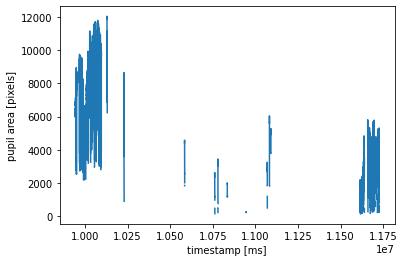

In [5]:
plot_pupil_size(samples)

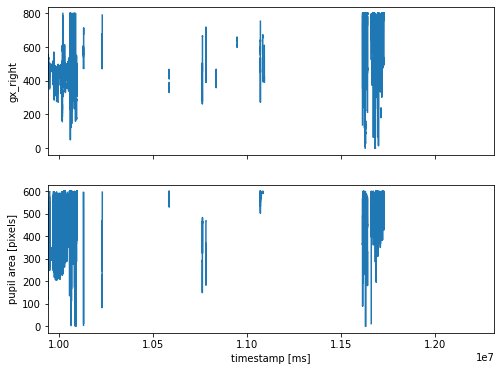

In [6]:
plot_coordinates_ts(samples)

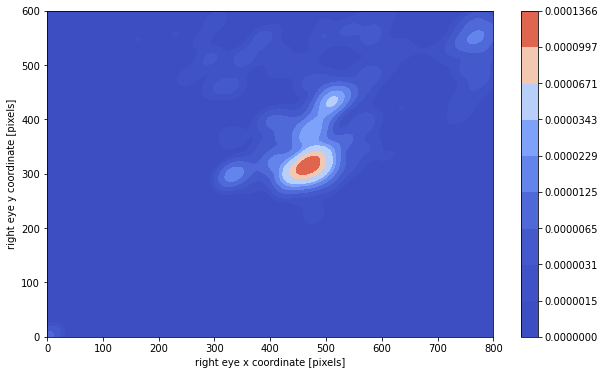

In [7]:
plot_heatmap_coordinate_density(samples)

# qct

In [8]:
samples, events, messages = edf.pread(str(DATA_PATH / et_session.qct_edf.values[0]), trial_marker=b"")

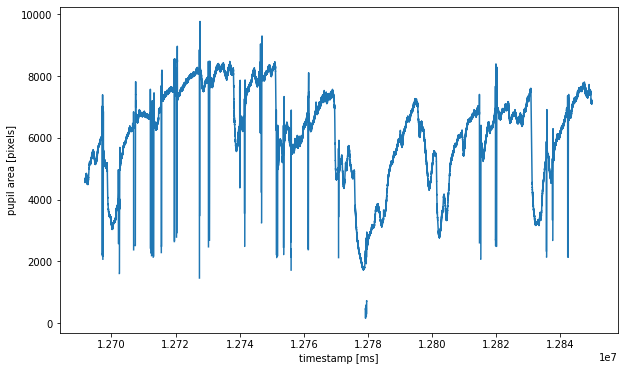

In [9]:
plot_pupil_size(samples)

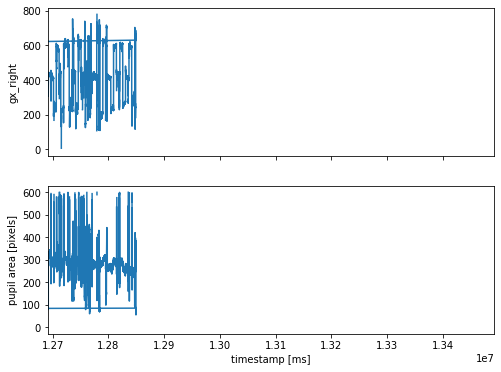

In [10]:
plot_coordinates_ts(samples)

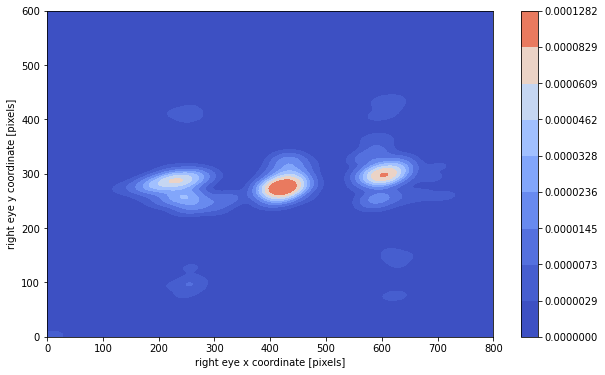

In [11]:
plot_heatmap_coordinate_density(samples)

# rest

In [ ]:
samples, events, messages = edf.pread(str(DATA_PATH / et_session.rest_edf.values[0]), trial_marker=b"")

In [ ]:
plot_heatmap_coordinate_density(samples)

# bht

In [ ]:
samples, events, messages = edf.pread(str(DATA_PATH / et_session.bht_edf.values[0]), trial_marker=b"")

In [ ]:
plot_heatmap_coordinate_density(samples)